In [1]:
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

In [2]:
FoV = np.radians(70)  # google maps earth view camera

In [3]:
origin = (40.743053, -73.9683201)
cam_alt = 373
heading = np.radians(333.56)
tilt = np.radians(57.77)

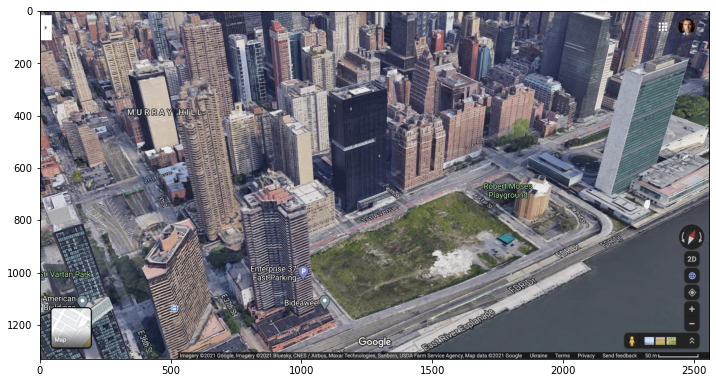

In [4]:
im = Image.open('NYC.png')
plt.figure(figsize=(12, 9))
plt.imshow(im)
plt.show()

In [5]:
H, W, _ = np.array(im).shape
W, H

(2560, 1330)

In [6]:
foc = W/2/np.tan(FoV/2)
foc

1828.0294486299067

In [7]:
u0, v0 = W/2, H/2
K = np.array([[foc, 0, u0],
             [0, foc, v0],
             [0,   0,  1]])

In [8]:
K.round()

array([[1.828e+03, 0.000e+00, 1.280e+03],
       [0.000e+00, 1.828e+03, 6.650e+02],
       [0.000e+00, 0.000e+00, 1.000e+00]])

In [9]:
# 1st Avenue
ave_1 = (40.741290, -73.975375)
ave_2 = (40.745095, -73.972592)
sign = (40.748166, -73.970330)
corner = (40.747523, -73.970423)
corner = (40.746588, -73.970573)
# corner = (40.747287, -73.971842) # black building

In [10]:
def get_extrinsic(alt, heading, tilt):
    r = alt * np.tan(np.radians(tilt))
    t = np.array([[r * np.cos(np.pi/2 - np.radians(heading)),
                  r * np.sin(np.pi/2 - np.radians(heading)), alt]]).T

    a1 = -heading
    a2 = tilt - np.pi
    # print(a1,a2)
    c1, s1 = np.cos(a1), np.sin(a1)
    c2, s2 = np.cos(a2), np.sin(a2)
    c3, s3 = 1, 0
    R = np.array([[c1*c3 - c2*s1*s3, -c1*s3 - c2*c3*s1, s1*s2],
                 [c3*s1 + c1*c2*s3, c1*c2*c3 - s1*s3, -c1*s2],
                 [s2*s3,        c3*s2,     c2]])
    t = np.array([[0, 0, alt]]).T
    return np.hstack([R.T, -R.T.dot(t)])

In [11]:
def get_xyz1(lat, lng, origin=origin):
    EARTH_RAD = 6370000  # at 40's latitude
    delta = np.array([np.radians(lat), np.radians(lng)]) - \
        np.array([np.radians(d) for d in origin])
    y, x = delta * EARTH_RAD * np.array([1, np.cos(np.radians(lat))])
    return np.array([x, y, 0.7, 1])

In [12]:
corner_xyz = get_xyz1(*corner)
ave_xyz_1 = get_xyz1(*ave_1)
ave_xyz_2 = get_xyz1(*ave_2)

In [13]:
vec = (ave_xyz_2 - ave_xyz_1)
vec = vec / np.linalg.norm(vec)
perp = vec.copy()
perp[0], perp[1] = perp[1], -perp[0]
WID = 50
DEP = 40
base = [corner_xyz, corner_xyz + vec * WID,
        corner_xyz + vec * WID + perp * DEP, corner_xyz + perp * DEP, corner_xyz]

In [14]:
def draw_highrise(draw, base, stories):
    poly = [p.copy() for p in base]
    for _ in range(stories):
        uvw = [K.dot(E).dot(p) for p in poly]
        pix = [(u/w, v/w) for u, v, w in uvw]
        # draw.polygon(pix, fill=(90,90,90), outline=(200,170,190))
        draw.line([pix[2], pix[3]], fill=(200, 180, 160), width=7)

        draw.line([pix[3], pix[4]], fill=(70, 60, 55), width=7)
        poly = [p + np.array([0, 0, 3, 0]) for p in poly]

    uvw = [K.dot(E).dot(p) for p in poly]
    pix = [(u/w, v/w) for u, v, w in uvw]
    draw.polygon(pix, fill=(90, 90, 90), outline=(200, 170, 1980))

In [15]:
sign_xyz1 = get_xyz1(*sign)

np.array([sign_xyz1]).T

array([[-169.28680981],
       [ 568.45042125],
       [   0.7       ],
       [   1.        ]])

In [16]:
get_xyz1(*origin)

array([0. , 0. , 0.7, 1. ])

In [17]:
E = get_extrinsic(cam_alt, heading, tilt)
print(np.round(E, 3))

[[ 8.95000e-01  4.45000e-01 -0.00000e+00 -0.00000e+00]
 [ 2.37000e-01 -4.78000e-01 -8.46000e-01  3.15526e+02]
 [-3.77000e-01  7.57000e-01 -5.33000e-01  1.98928e+02]]


In [18]:

u, v, w = K.dot(E).dot(np.array([get_xyz1(*sign)]).T)
x, y = (u/w)[0], (v/w)[0]
x, y

(1547.8642966157636, 673.6514200414127)

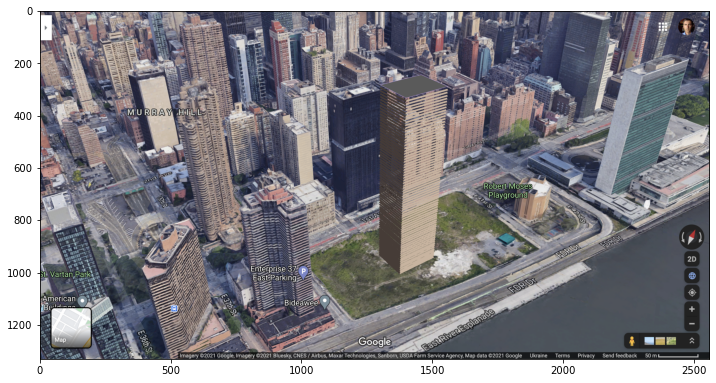

In [19]:
draw = ImageDraw.Draw(im)
# draw.line((x, y, x, y - 150), fill=90, width=10)
draw_highrise(draw, base, 70)
plt.figure(figsize=(12, 9))
plt.imshow(im)
plt.show()